# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [3]:
data = pd.read_csv('cost_revenue_dirty.csv')

# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB


In [5]:
data

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,8/2/1915,The Birth of a Nation,"$110,000","$11,000,000","$10,000,000"
1,5140,5/9/1916,Intolerance,"$385,907",$0,$0
2,5230,12/24/1916,"20,000 Leagues Under the Sea","$200,000","$8,000,000","$8,000,000"
3,5299,9/17/1920,Over the Hill to the Poorhouse,"$100,000","$3,000,000","$3,000,000"
4,5222,1/1/1925,The Big Parade,"$245,000","$22,000,000","$11,000,000"
...,...,...,...,...,...,...
5386,2950,10/8/2018,Meg,"$15,000,000",$0,$0
5387,126,12/18/2018,Aquaman,"$160,000,000",$0,$0
5388,96,12/31/2020,Singularity,"$175,000,000",$0,$0
5389,1119,12/31/2020,Hannibal the Conqueror,"$50,000,000",$0,$0


In [6]:
data.duplicated().sum()

np.int64(0)

### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [7]:
price_cols = ['USD_Production_Budget', 'USD_Worldwide_Gross', 'USD_Domestic_Gross']
conv_to_int = lambda v: int(v.strip('$').replace(',', ''))

for col in price_cols:
    data[col] = data[col].apply(conv_to_int)

In [8]:
data[price_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   USD_Production_Budget  5391 non-null   int64
 1   USD_Worldwide_Gross    5391 non-null   int64
 2   USD_Domestic_Gross     5391 non-null   int64
dtypes: int64(3)
memory usage: 126.5 KB


**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [9]:
data['Release_Date'] = pd.to_datetime(data['Release_Date'], format='%m/%d/%Y')
data['Release_Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5391 entries, 0 to 5390
Series name: Release_Date
Non-Null Count  Dtype         
--------------  -----         
5391 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 42.2 KB


### Descriptive Statistics

**Challenge**: 

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [10]:
data.describe()

,Rank,Release_Date,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
count,"5,391.00",5391,"5,391.00","5,391.00","5,391.00"
mean,"2,696.00",2003-09-19 15:02:02.203672704,"31,113,737.58","88,855,421.96","41,235,519.44"
min,1.00,1915-08-02 00:00:00,"1,100.00",0.00,0.00
25%,"1,348.50",1999-12-02 12:00:00,"5,000,000.00","3,865,206.00","1,330,901.50"
50%,"2,696.00",2006-06-23 00:00:00,"17,000,000.00","27,450,453.00","17,192,205.00"
75%,"4,043.50",2011-11-23 00:00:00,"40,000,000.00","96,454,455.00","52,343,687.00"
max,"5,391.00",2020-12-31 00:00:00,"425,000,000.00","2,783,918,982.00","936,662,225.00"
std,"1,556.39",NaN,"40,523,796.88","168,457,757.00","66,029,346.27"


# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [11]:
sum(data['USD_Domestic_Gross']==0)

512

In [12]:
# mask = (data['USD_Worldwide_Gross']==0) & (data['USD_Domestic_Gross']==0)

data[data['USD_Domestic_Gross']==0].sort_values(
    by="USD_Production_Budget", ascending=False
).head(25)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla",80000000,4547660,0
4294,566,2012-12-31,Astérix et Obélix: Au service de Sa Majesté,77600000,60680125,0
5058,880,2015-11-12,The Ridiculous 6,60000000,0,0
5338,879,2017-04-08,The Dark Tower,60000000,0,0
5389,1119,2020-12-31,Hannibal the Conqueror,50000000,0,0
4295,1230,2012-12-31,Foodfight!,45000000,73706,0


**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [13]:
sum(data['USD_Worldwide_Gross']==0)

357

In [14]:
data[data['USD_Worldwide_Gross']==0].sort_values(
    by="USD_Production_Budget", ascending=False
).head(25)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5058,880,2015-11-12,The Ridiculous 6,60000000,0,0
5338,879,2017-04-08,The Dark Tower,60000000,0,0
5389,1119,2020-12-31,Hannibal the Conqueror,50000000,0,0
5092,1435,2015-12-31,The Crow,40000000,0,0
3300,1631,2008-12-31,Black Water Transit,35000000,0,0
5045,1656,2015-10-30,Freaks of Nature,33000000,0,0


### Filtering on Multiple Conditions

In [15]:
mask = (data["USD_Domestic_Gross"] == 0) & (data["USD_Worldwide_Gross"] > 0)

data[mask].sort_values(by="USD_Worldwide_Gross", ascending=False)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
2836,1270,2006-12-31,Les Bronzés 3: amis pour la vie,42000000,83833602,0
4960,3283,2015-08-05,La famille Bélier,11000000,74056184,0
3809,2154,2010-12-31,Sammy's avonturen: De geheime doorgang,25000000,71594792,0
3769,2776,2010-11-05,Haeundae,16000000,64733391,0
3051,2665,2007-12-31,Taxi 4,17500000,60865364,0
...,...,...,...,...,...,...
5141,4076,2016-02-09,Yoga Hosers,5000000,2199,0
3573,5015,2010-01-26,B-Girl,700000,1160,0
5103,4625,2015-12-31,"To Be Frank, Sinatra at 100",2000000,926,0
4772,5005,2014-12-31,Destiny,750000,450,0


**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

Hint: This time you'll have to use the `and` keyword.

In [16]:
data.query("USD_Domestic_Gross == 0 and USD_Worldwide_Gross > 0")

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0
...,...,...,...,...,...,...
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0
5348,2225,2017-05-05,Chāi dàn zhuānjiā,23000000,58807172,0
5360,4832,2017-07-03,Departure,1100000,27561,0
5372,1856,2017-08-25,Ballerina,30000000,48048527,0


### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [17]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

In [18]:
mask = (data["Release_Date"] > scrape_date)

print(len(data[mask]))
data[mask]

7


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5386,2950,2018-10-08,Meg,15000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5388,96,2020-12-31,Singularity,175000000,0,0
5389,1119,2020-12-31,Hannibal the Conqueror,50000000,0,0
5390,2517,2020-12-31,"Story of Bonnie and Clyde, The",20000000,0,0


In [19]:
data_clean = data[~mask].copy()
data_clean

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000
1,5140,1916-05-09,Intolerance,385907,0,0
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000
...,...,...,...,...,...,...
5379,1295,2017-10-02,John Wick: Chapter Two,40000000,166893990,92029184
5380,70,2017-10-03,Kong: Skull Island,185000000,561137727,168052812
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066
5382,1254,2017-12-05,Snatched,42000000,57850343,45850343


### Films that Lost Money

**Challenge**: 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [20]:
lost_money_films = data_clean.query("USD_Worldwide_Gross < USD_Production_Budget")
len(lost_money_films) / len(data_clean) * 100

37.27711738484398

# Seaborn for Data Viz: Bubble Charts

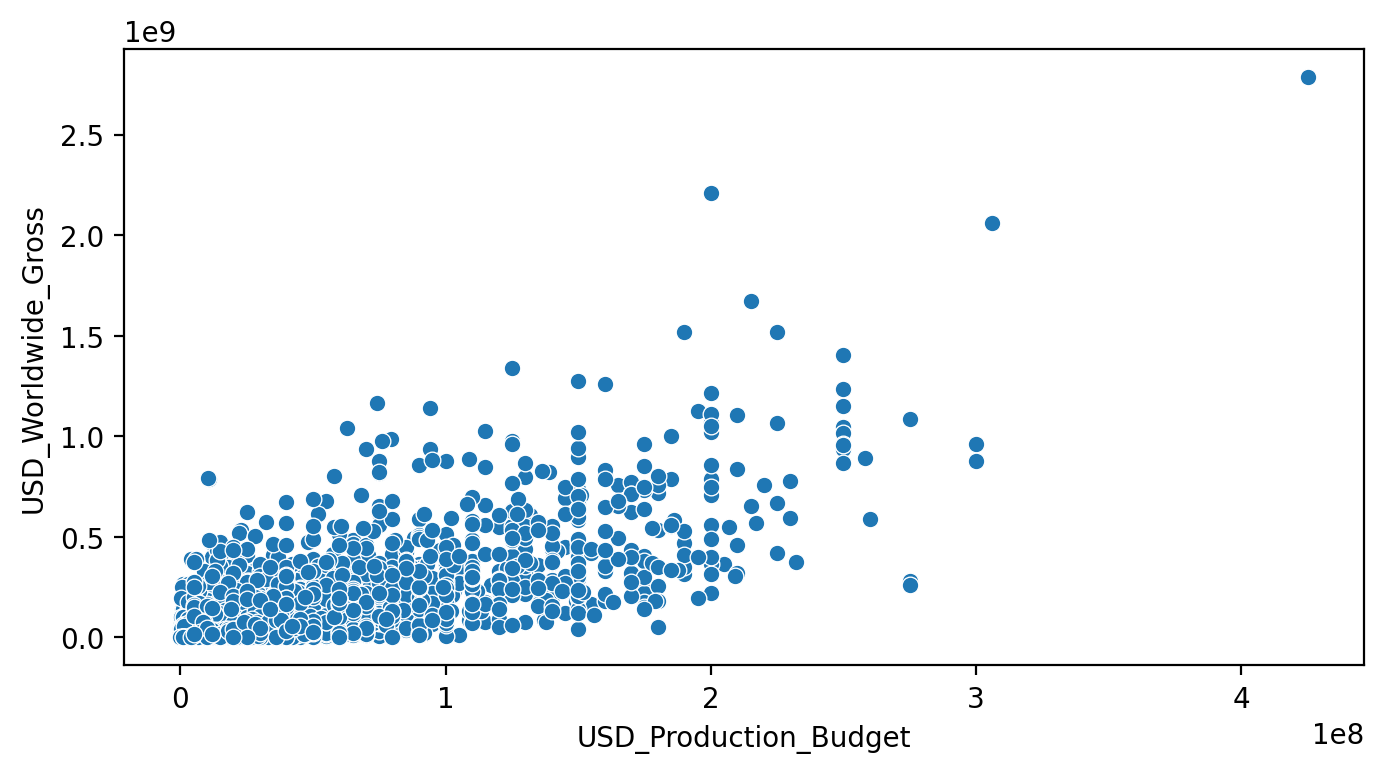

In [21]:
plt.figure(figsize=(8, 4), dpi=200)

sns.scatterplot(data=data_clean, x="USD_Production_Budget", y="USD_Worldwide_Gross")

plt.show()

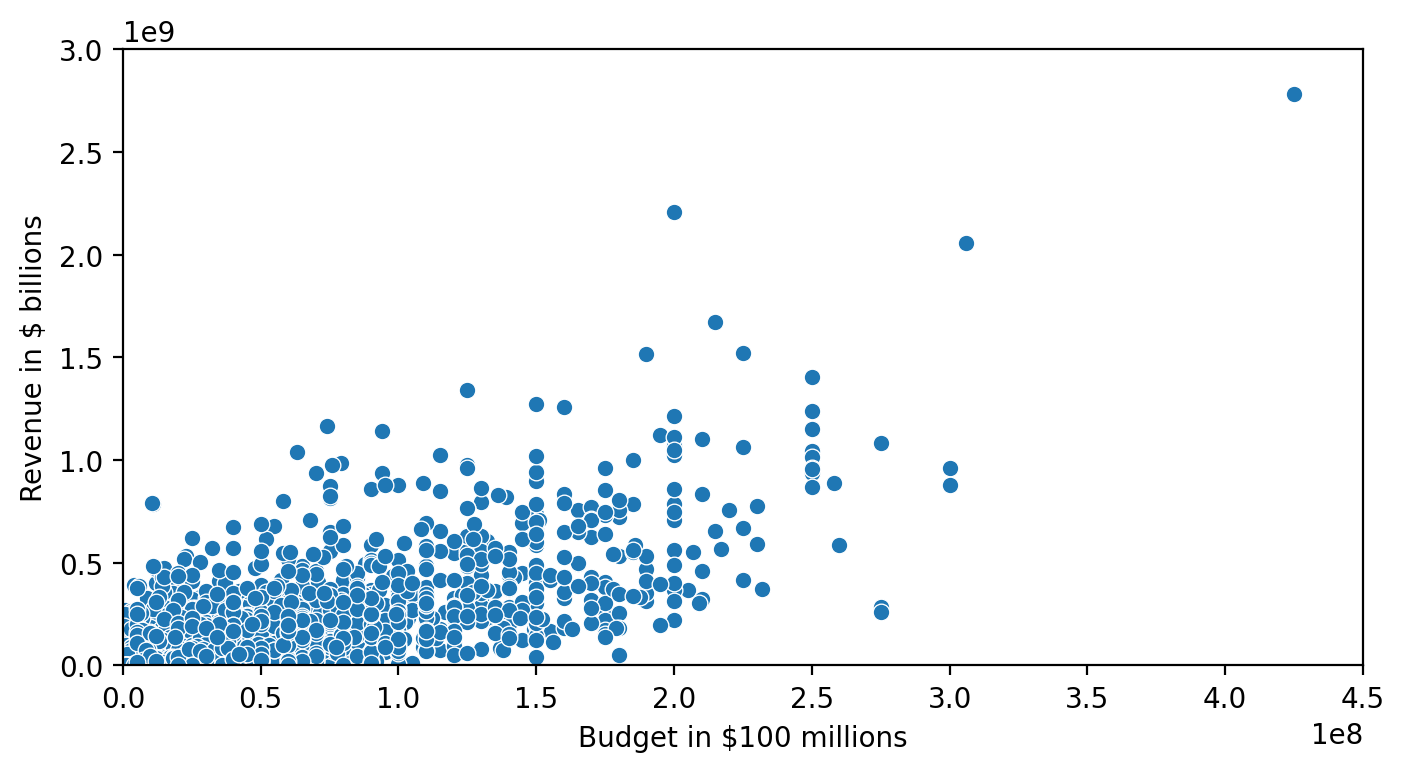

In [22]:
plt.figure(figsize=(8, 4), dpi=200)

ax = sns.scatterplot(
    data=data_clean,
    x="USD_Production_Budget",
    y="USD_Worldwide_Gross"
)

ax.set(
    xlim=(0, 450_000_000),
    ylim=(0, 3_000_000_000),
    xlabel="Budget in $100 millions",
    ylabel="Revenue in $ billions",
)

plt.show()

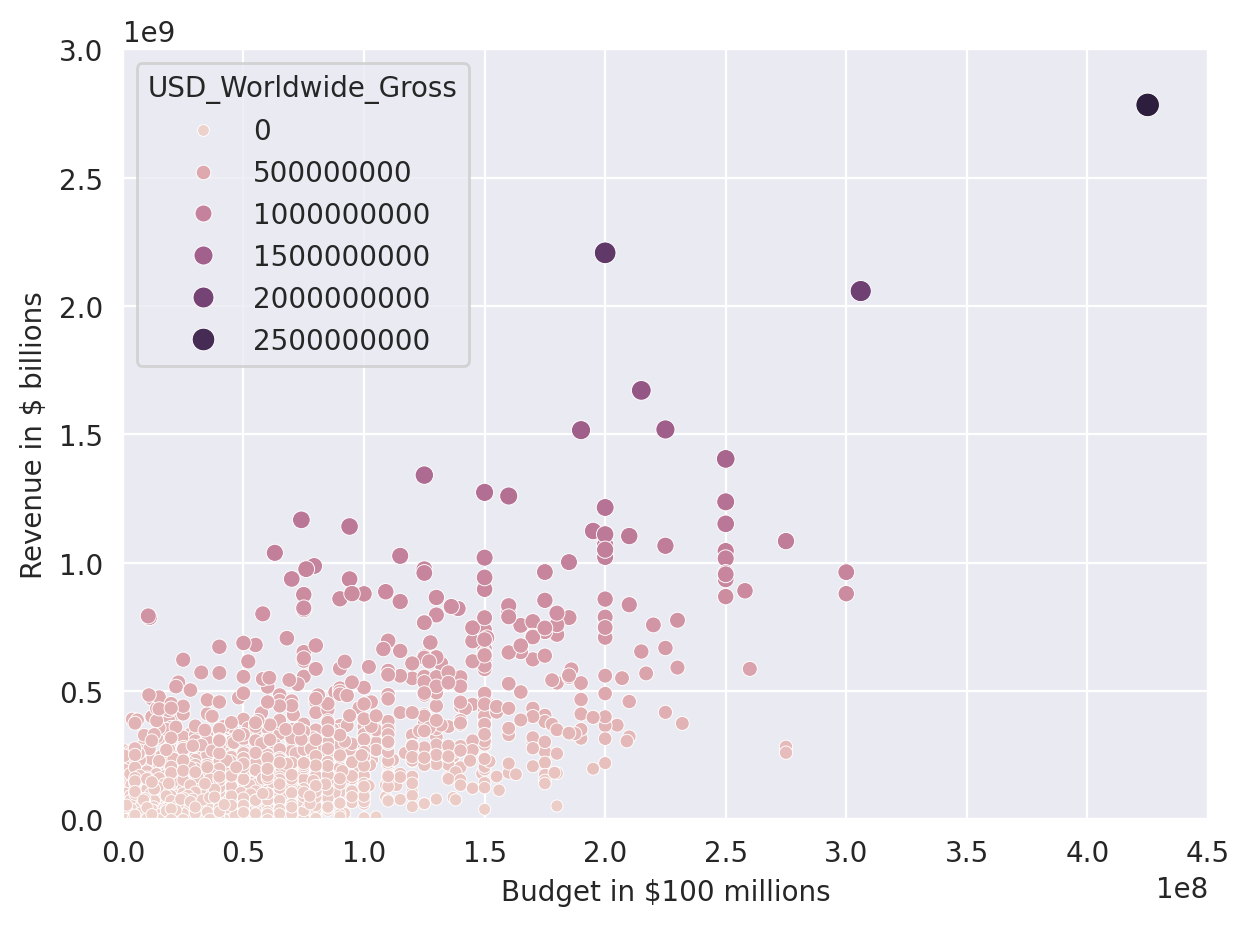

In [23]:
plt.figure(figsize=(7, 5), dpi=200)

# set styling on a single chart
with sns.axes_style("darkgrid"):
    ax = sns.scatterplot(
        data=data_clean,
        x="USD_Production_Budget",
        y="USD_Worldwide_Gross",
        hue="USD_Worldwide_Gross",  # color
        size="USD_Worldwide_Gross",  # dot size
    )

    ax.set(
        xlim=(0, 450_000_000),
        ylim=(0, 3_000_000_000),
        xlabel="Budget in $100 millions",
        ylabel="Revenue in $ billions",
    )

plt.show()

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>

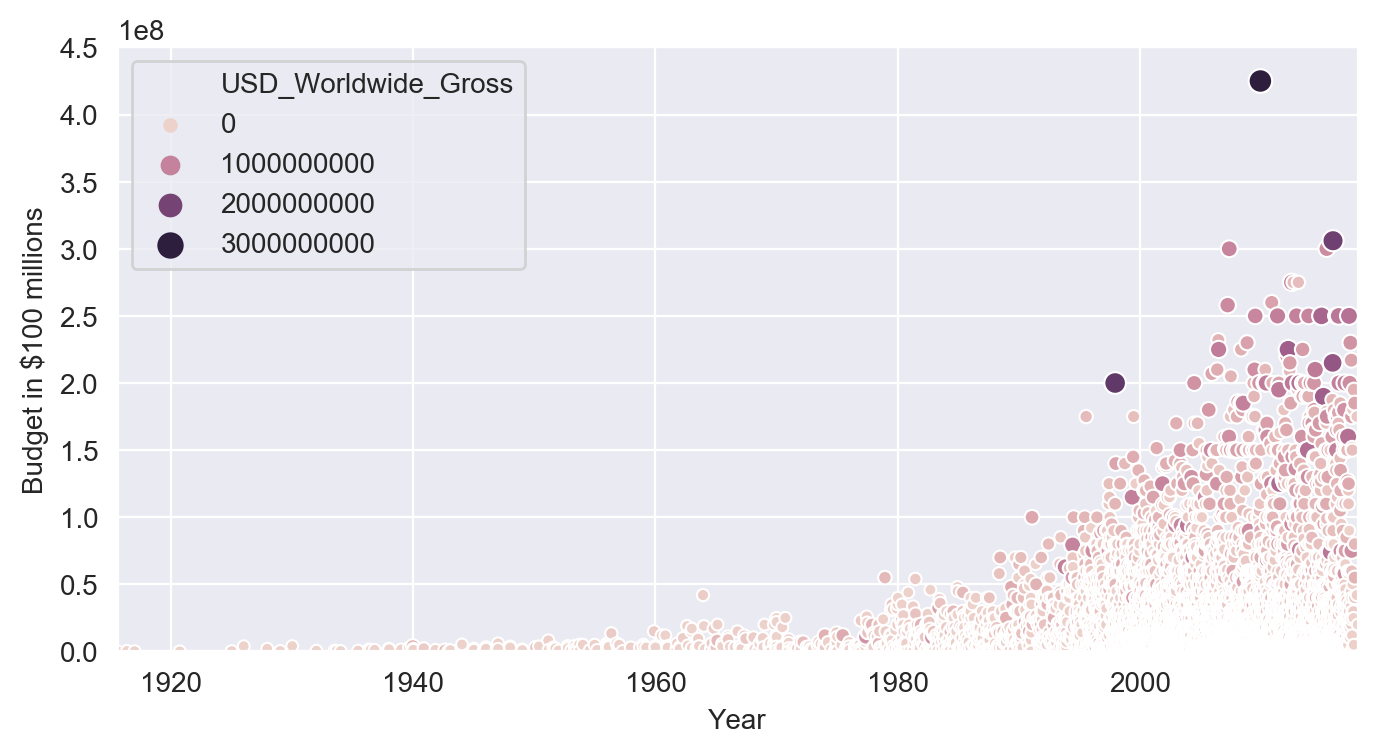

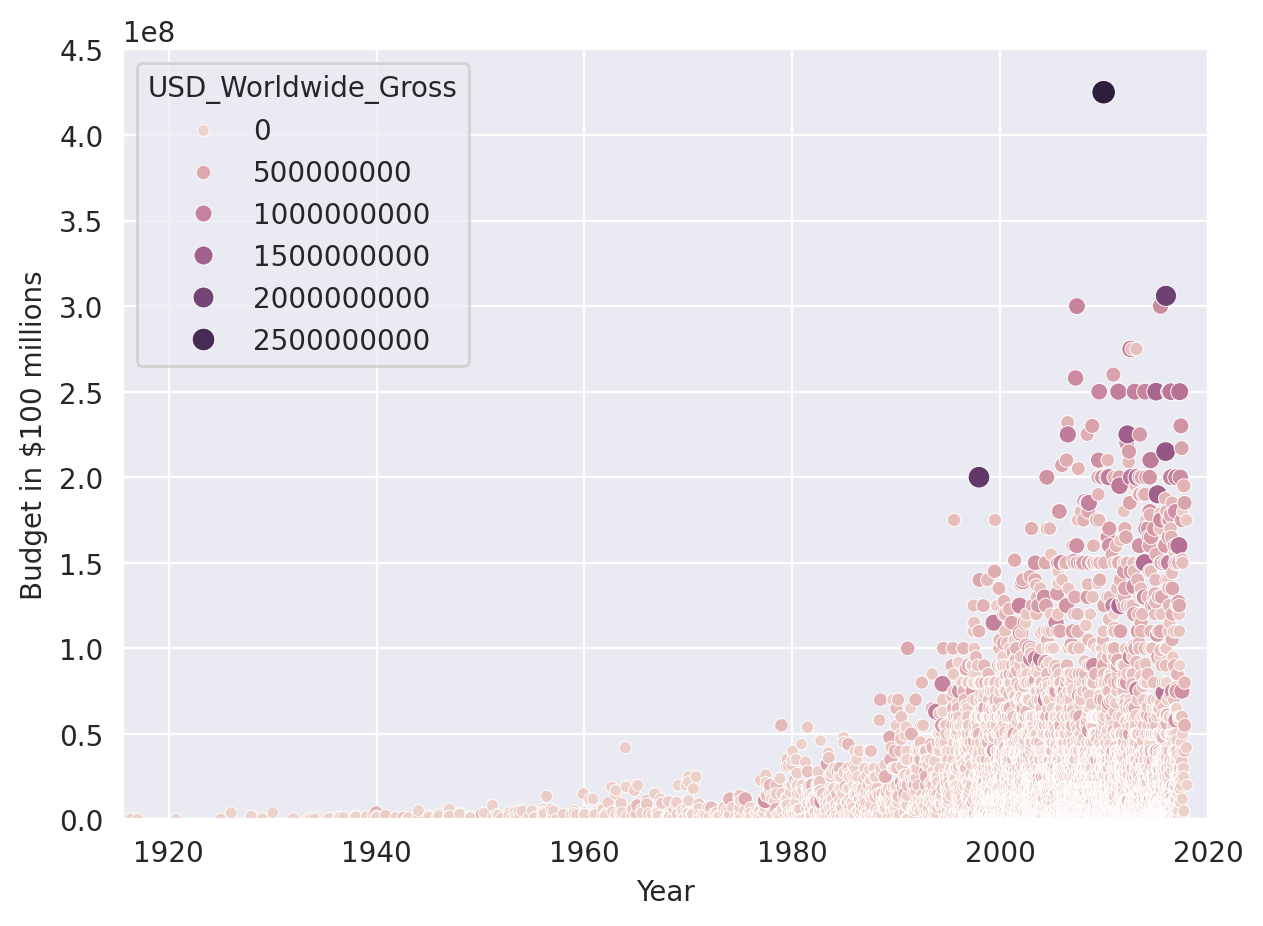

In [24]:
plt.figure(figsize=(7, 5), dpi=200)

# set styling on a single chart
with sns.axes_style("darkgrid"):
    ax = sns.scatterplot(
        data=data_clean,
        x="Release_Date",
        y="USD_Production_Budget",
        hue="USD_Worldwide_Gross",  # color
        size="USD_Worldwide_Gross",  # dot size
    )

    ax.set(
        xlim=(data.Release_Date.min(), pd.Timestamp("2020-1-1")),
        ylim=(0, 450_000_000),
        xlabel="Year",
        ylabel="Budget in $100 millions",
    )

plt.show()

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release. 

<img src=https://i.imgur.com/0VEfagw.png width=650> 

Here's how: 
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [25]:
data_clean["Release_Date"].apply(lambda x: x.year)

0       1915
1       1916
2       1916
3       1920
4       1925
        ... 
5379    2017
5380    2017
5381    2017
5382    2017
5383    2017
Name: Release_Date, Length: 5384, dtype: int64

In [26]:
pd.DatetimeIndex(data_clean["Release_Date"]).year

Index([1915, 1916, 1916, 1920, 1925, 1925, 1927, 1929, 1930, 1931,
       ...
       2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
      dtype='int32', name='Release_Date', length=5384)

In [27]:
modul_idx = (pd.DatetimeIndex(data_clean["Release_Date"]).year % 10)
decades = pd.DatetimeIndex(data_clean["Release_Date"]).year - modul_idx

data_clean["Decade"] = decades.copy()
data_clean

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,1910
1,5140,1916-05-09,Intolerance,385907,0,0,1910
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000,1910
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000,1920
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000,1920
...,...,...,...,...,...,...,...
5379,1295,2017-10-02,John Wick: Chapter Two,40000000,166893990,92029184,2010
5380,70,2017-10-03,Kong: Skull Island,185000000,561137727,168052812,2010
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066,2010
5382,1254,2017-12-05,Snatched,42000000,57850343,45850343,2010


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [28]:
film_mask = data_clean.Release_Date < pd.to_datetime("1970")
old_films = data_clean[film_mask].copy()
new_films = data_clean[~film_mask].copy()

In [29]:
old_films.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 0 to 152
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   153 non-null    int64         
 1   Release_Date           153 non-null    datetime64[ns]
 2   Movie_Title            153 non-null    object        
 3   USD_Production_Budget  153 non-null    int64         
 4   USD_Worldwide_Gross    153 non-null    int64         
 5   USD_Domestic_Gross     153 non-null    int64         
 6   Decade                 153 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 9.0+ KB


In [30]:
old_films.loc[[old_films["USD_Production_Budget"].idxmax()]]

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
109,1253,1963-12-06,Cleopatra,42000000,71000000,57000000,1960


In [31]:
new_films.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5231 entries, 153 to 5383
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   5231 non-null   int64         
 1   Release_Date           5231 non-null   datetime64[ns]
 2   Movie_Title            5231 non-null   object        
 3   USD_Production_Budget  5231 non-null   int64         
 4   USD_Worldwide_Gross    5231 non-null   int64         
 5   USD_Domestic_Gross     5231 non-null   int64         
 6   Decade                 5231 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 306.5+ KB


# Seaborn Regression Plots

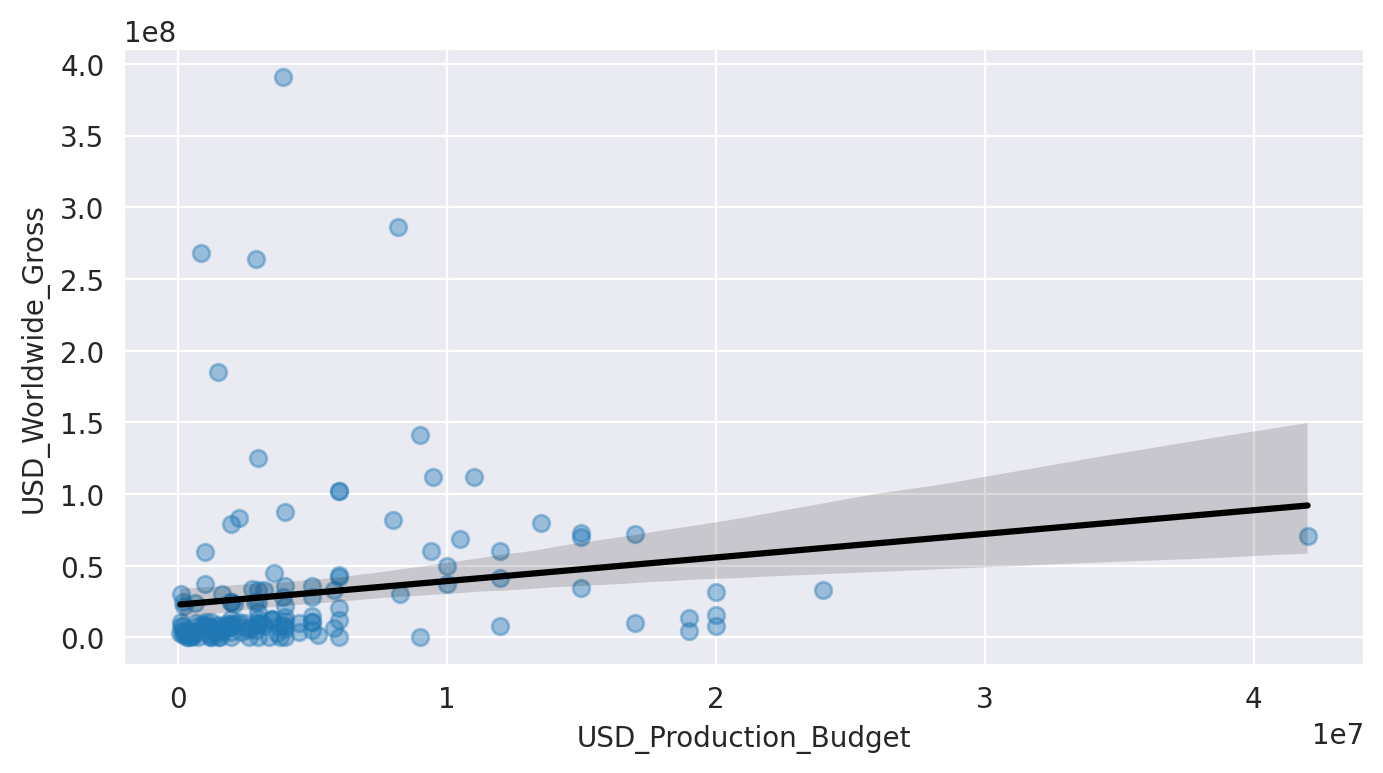

In [60]:
plt.figure(figsize=(8, 4), dpi=200)

with sns.axes_style("darkgrid"):
    sns.regplot(
        data=old_films,
        x="USD_Production_Budget",
        y="USD_Worldwide_Gross",
        scatter_kws={"alpha": 0.4},
        line_kws={"color": "black"},
    )

plt.show()

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

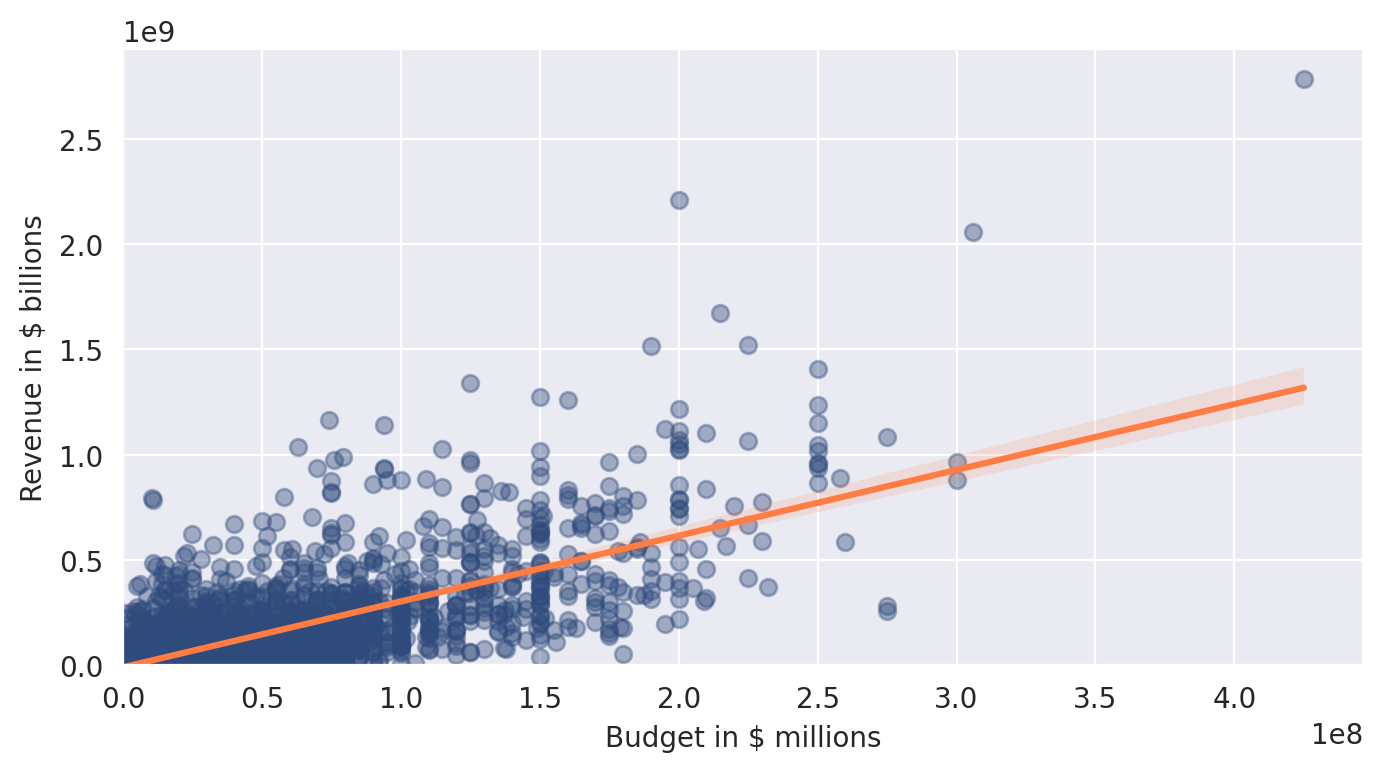

In [65]:
plt.figure(figsize=(8, 4), dpi=200)

with sns.axes_style("darkgrid"):
    ax = sns.regplot(
        data=new_films,
        x="USD_Production_Budget",
        y="USD_Worldwide_Gross",
        color="#2f4b7c",
        scatter_kws={"alpha": 0.4},
        line_kws={"color": "#ff7c43"},
    )
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel("Budget in $ millions")
    ax.set_ylabel("Revenue in $ billions")
    
    # ax.set(
    #     ylim=(0, 3000000000),
    #     xlim=(0, 450000000),
    #     ylabel='Revenue in $ billions',
    #     xlabel='Budget in $100 millions'
    # )

plt.show()

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [85]:
X = new_films[["USD_Production_Budget"]].reset_index(drop=True).copy()
y = new_films[["USD_Worldwide_Gross"]].reset_index(drop=True).copy()

X

,USD_Production_Budget
0,25000000
1,22000000
2,12000000
3,11000000
4,3500000
...,...
5226,40000000
5227,185000000
5228,175000000
5229,42000000


In [86]:
y

,USD_Worldwide_Gross
0,0
1,5000000
2,62500000
3,2200000
4,81600000
...,...
5226,166893990
5227,561137727
5228,140012608
5229,57850343


In [89]:
# Find the best-fit line
lin_reg = LinearRegression()
lin_reg.fit(X, y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [95]:
# Theta zero
print(lin_reg.intercept_)

# Theta one
print(lin_reg.coef_)

[-8650768.00661027]
[[3.12259592]]


In [98]:
# R-squared
lin_reg.score(X, y)

0.5577032617720403

**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [99]:
X_old = old_films[["USD_Production_Budget"]].reset_index(drop=True).copy()
y_old = old_films[["USD_Worldwide_Gross"]].reset_index(drop=True).copy()

X_old

,USD_Production_Budget
0,110000
1,385907
2,200000
3,100000
4,245000
...,...
148,20000000
149,6000000
150,24000000
151,8000000


In [100]:
y_old

,USD_Worldwide_Gross
0,11000000
1,0
2,8000000
3,3000000
4,22000000
...,...
148,31678778
149,102308900
150,33208099
151,82000000


In [102]:
lin_reg_old = LinearRegression()
lin_reg_old.fit(X_old, y_old)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [103]:
print(f"{lin_reg_old.intercept_=}")
print(f"{lin_reg_old.coef_=}")

lin_reg_old.intercept_=array([22821538.63508039])
lin_reg_old.coef_=array([[1.64771314]])


In [105]:
# R-squared
lin_reg_old.score(X_old, y_old)

0.02937258620576877

# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [115]:
revenue = lin_reg_old.predict([[350_000_000]])
print("Revenue for $350 mln budget:", revenue[0][0])  # -> nearly $600 mln.

Revenue for $350 mln budget: 599521139.0388364


/home/javohir/Engineering/100-days-python-bootcamp/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [116]:
22821538 + 1.64771314 * 350000000

599521137.0

In [120]:
budget = 350000000
revenue_estimate = lin_reg_old.intercept_[0] + lin_reg_old.coef_[0,0]*budget
revenue_estimate = round(revenue_estimate, -6)
print(f'The estimated revenue for a $350 film is around ${revenue_estimate:.10}.')

The estimated revenue for a $350 film is around $600000000.0.
